# Bibliotecas

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import MinMaxScaler

# Hiperparâmetros
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from skopt import BayesSearchCV

# statistics / ML
# from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Obtenção dos dados

In [3]:
import os
if not os.path.exists('data'):
    os.makedirs('data')

In [4]:
# !kaggle datasets download -d ahmedabbas757/coffee-sales -p data --unzip

# 2. Importação dos dados

In [5]:
data = pd.read_excel('data/Coffee Shop Sales.xlsx')

In [6]:
print(f'Linhas: {data.shape[0]}')
print(f'Colunas: {data.shape[1]}')

Linhas: 149116
Colunas: 11


In [7]:
data.head(3)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg


# 3. Inspeção geral dos dados

| **Variável**            | **Descrição**                                                                                   |
|------------------------|-----------------------------------------------------------------------------------------------|
| **transaction_id**     | ID sequencial único representando uma transação individual                                    |
| **transaction_date**   | Data da transação (MM/DD/YY)                                                                  |
| **transaction_time**   | Horário da transação (HH:MM:SS)                                                               |
| **transaction_qty**    | Quantidade de itens vendidos                                                                  |
| **store_id**           | ID único da cafeteria onde a transação ocorreu                                               |
| **store_location**     | Localização da cafeteria onde a transação ocorreu                                            |
| **product_id**         | ID único do produto vendido                                                                  |
| **unit_price**         | Preço de varejo do produto vendido                                                           |
| **product_category**   | Descrição da categoria do produto                                                            |
| **product_type**       | Descrição do tipo de produto                                                                 |
| **product_detail**     | Descrição do detalhe do produto                                                              |


# 4.Split dos dados

`Observação`: Como o projeto envolve séries temporais, é essencial que os conjuntos de treino e teste sejam divididos com base no tempo, preservando a ordem cronológica dos dados. Seleções aleatórias podem causar vazamento de informações, uma vez que dados futuros poderiam influenciar a previsão de eventos passados.

In [8]:
# Exploração do ponto de corte (data)
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['transaction_date'].dt.to_period('M').unique()

<PeriodArray>
['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06']
Length: 6, dtype: period[M]

* Os dados disponíveis correspondem a 6 meses de vendas da cafeteria
* O objetivo é usar os dados dos primeiros 5 meses (janeiro, fevereiro, março, abril e maio) para prever o último mês (junho)
* O agrupamento será feito por dia, ou seja, 150 dias para treino (5 meses) e 30 dias para o teste (1 mês)

In [9]:
# Ponto de corte
train_end_date = '2023-05-31'

In [10]:
# Criando os conjuntos de treino e teste
train = data[data['transaction_date'] <= train_end_date]
test = data[data['transaction_date'] > train_end_date]

print(f'Linhas do treino {train.shape[0]}')
print(f'Linhas do teste {test.shape[0]}')

Linhas do treino 113764
Linhas do teste 35352


# 5. EDA

In [11]:
# Mudar as que tem faturamento total pra média dos meses no lugar da soma?

* Foi realizada uma EDA geral para fins de conhecimento da base de dados e para verificar possíveis insights
* A EDA foi realizada considerando apenas os dados separados para o treino

### 5.0 Considerações gerais

In [12]:
train = train.copy()

In [13]:
# Cor dos gráficos
c1 = '#8B4513'
c2 = 'YlOrBr_r'
c3 = 'YlOrBr'
c4 = '#FF7F32'
c5= '#FFA500'

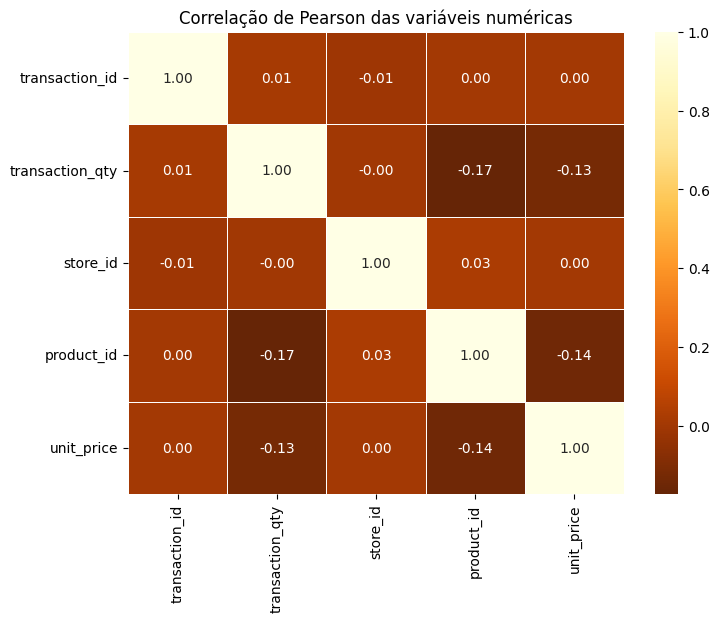

In [14]:
# Correlação das variáveis numéricas

numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
train_numeric = train[numeric_columns]
correlation = train_numeric.corr()

plt.figure(figsize=(8, 6))  # Define o tamanho da figura
sns.heatmap(correlation, annot=True, cmap=c2, fmt='.2f', linewidths=0.5)
plt.title('Correlação de Pearson das variáveis numéricas')
plt.show()

A análise das correlações lineares entre as variáveis numéricas e o target revelou que não há relações lineares significativas na maior parte dos casos. No entanto, foi identificado que a variável `transaction_qty` apresenta uma correlação linear negativa com o target. Esse resultado é consistente com a lógica esperada, já que produtos com preços mais elevados tendem a ter menor volume de vendas.

### 5.1 Quantidade de transações por localidade

A localidade com mais vendas foi a de Lower Manhattan (33,50%), Hell's Kitchen (33,40%) e Astoria (33,11%).

In [15]:
location_sales = train.groupby('store_location', as_index=False).agg(sum_transaction_qty=('transaction_qty','sum'))

location_sales['percentage'] = np.round((location_sales['sum_transaction_qty'] / location_sales['sum_transaction_qty'].sum()) * 100,2)

location_sales.sort_values(by='percentage', ascending=False,inplace=True)

location_sales

,store_location,sum_transaction_qty,percentage
2,Lower Manhattan,54777,33.50
1,Hell's Kitchen,54613,33.40
0,Astoria,54138,33.11


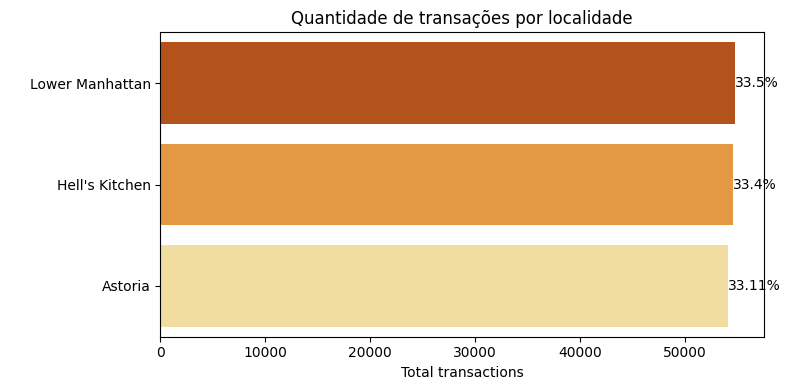

In [16]:
ordered_locations = location_sales.sort_values(by='sum_transaction_qty', ascending=False)['store_location']

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(
    x='sum_transaction_qty',
    y='store_location',
    data=location_sales,
    palette=c2,
    order=ordered_locations  # Forçando a ordem correta
)

# Porcentagens
for index, row in location_sales.iterrows():
    plt.text(
        row['sum_transaction_qty'] + 0.5,
        row['store_location'],
        f"{row['percentage']}%", 
        va='center',
        fontsize=10
    )

plt.title('Quantidade de transações por localidade', fontsize=12)
plt.xlabel('Total transactions', fontsize=10)
plt.ylabel(' ')
plt.tight_layout()
plt.show()

### 5.2 Total de faturamento por localidade ao longo do meses

As localidades tiveram o faturamento semelhante ao longo dos meses, assim como suas distribuições na base de dados.

In [17]:
df_stores = train.groupby(['store_location','transaction_date']).agg(sum_unit_price=('unit_price', 'sum'), 
                                                                     count_transaction_id=('transaction_id', 'count')).reset_index()

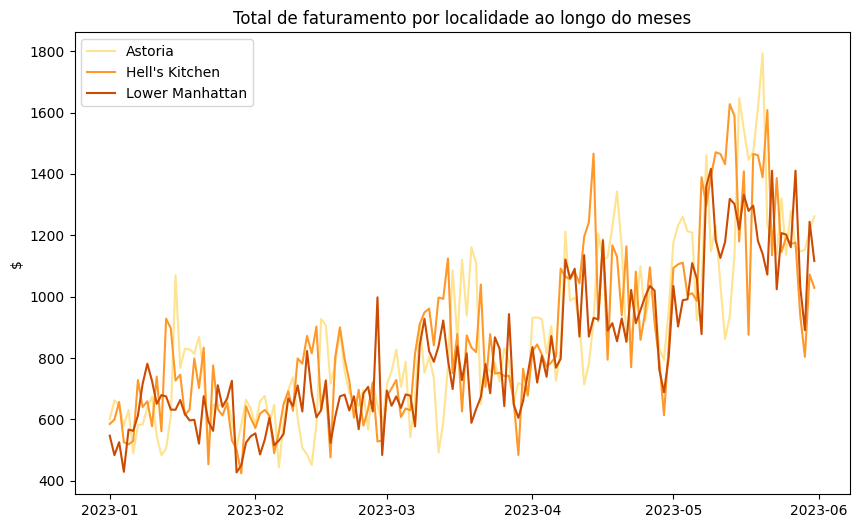

In [18]:
# Paleta de cores
palette = sns.color_palette(c3, len(df_stores['store_location'].unique()))

# Gráfico
plt.figure(figsize=(10, 6))
for idx, store in enumerate(df_stores['store_location'].unique()):
    plt.plot(
        df_stores.loc[df_stores['store_location'] == store, 'transaction_date'], 
        df_stores.loc[df_stores['store_location'] == store, 'sum_unit_price'], 
        label=store, 
        color=palette[idx],
    )

plt.title('Total de faturamento por localidade ao longo do meses', fontsize=12)
plt.ylabel('$')
plt.legend()
plt.show()

### 5.3 Faturamento total por mês

O faturamento total ao longo dos meses apresentou algumas variações crescentes. A média dos valores de janeiro a abril é aproximadamente $ 67,924. O mês de maio está 66.48% acima da média desses meses. Como o comportamento foi crescente, há a possibilidade de o mês de junho (que será feita a previsão) acompanhe esse crescimento.

In [19]:
# Criando uma nova coluna com o mês e o ano isolados
train.loc[:, 'transaction_month'] = train['transaction_date'].dt.to_period('M')

# Agrupando o faturamento por mês
transaction_month_price = train.groupby('transaction_month',as_index=False).agg(sum_unit_price=('unit_price','sum'))
transaction_month_price.sort_values(by='sum_unit_price',ascending=False)

,transaction_month,sum_unit_price
4,2023-05,113076.91
3,2023-04,85709.58
2,2023-03,71833.08
0,2023-01,59018.04
1,2023-02,55134.34


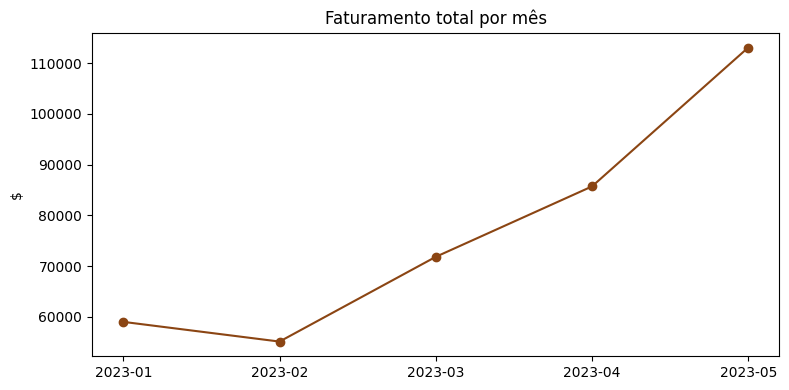

In [20]:
# Convertendo a coluna 'transaction_month' para string para o gráfico
transaction_month_price['transaction_month'] = transaction_month_price['transaction_month'].astype(str)

# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(
    transaction_month_price['transaction_month'], 
    transaction_month_price['sum_unit_price'], 
    color=c1,
    marker='o'
)

plt.title('Faturamento total por mês', fontsize=12)
plt.ylabel('$')
plt.tight_layout()
plt.show()

💡 Devido ao que foi comentado acima nesta seção, existe a possibilidade de que modelos lineares possam performar melhor nesse conjunto de dados. O fato de os valores apresentarem um crescimento consistente sugere que uma relação linear pode ser uma boa aproximação para o padrão dos dados.

### 5.4 Faturamrento total por categoria do produto

Os produtos que mais costumam vender são: Coffee, Tea e Bakery. Foram considerados todos os meses.

In [21]:
# Agrupando o faturamento por categoria de produto

faturamento_por_categoria = train.groupby('product_category',as_index=False).agg(sum_unit_price=('unit_price','sum'))
faturamento_por_categoria.sort_values(by='sum_unit_price',ascending=False,inplace=True)

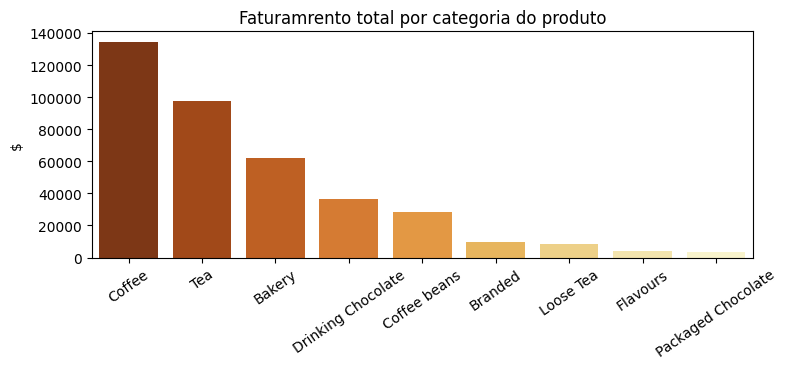

In [22]:
# Gráfico

plt.figure(figsize=(8, 4))
sns.barplot(x='product_category', y='sum_unit_price', data=faturamento_por_categoria, palette=c2)
plt.title('Faturamrento total por categoria do produto', fontsize=12)
plt.xticks(rotation=35)
plt.tight_layout()
plt.xlabel(' ')
plt.ylabel('$')
plt.show()

In [23]:
faturamento_por_categoria

,product_category,sum_unit_price
2,Coffee,134321.25
8,Tea,97850.65
0,Bakery,62024.22
4,Drinking Chocolate,36394.00
3,Coffee beans,28228.60
1,Branded,9966.00
6,Loose Tea,8442.95
5,Flavours,4128.80
7,Packaged Chocolate,3415.48


### 5.5 Faturamento total por horário do dia

10, 9 e 8h da manhã costumam ser os horários com maior faturamento total considerando todos os meses.

In [24]:
# Extraindo a parte inteira da coluna de hora
train['hour'] = train['transaction_time'].apply(lambda x: x.hour)

# Agrupando por hora e somando o `unit_price`
total_ganho_por_horario = train.groupby('hour')['unit_price'].sum().reset_index()
total_ganho_por_horario.columns = ['hour', 'sum_unit_price']
total_ganho_por_horario.sort_values(by='sum_unit_price', ascending=False,inplace=True)
total_ganho_por_horario

,hour,sum_unit_price
4,10,49504.77
3,9,47011.45
2,8,46800.60
1,7,35284.74
5,11,24686.07
10,16,23061.84
9,15,22834.92
8,14,22420.99
7,13,22140.31
11,17,21863.12


Após as 10h, há uma redução significativa, que mantem-se estável até cair completamente (20h). A diminuição do horário das 20h faz sentido, considerando que é o último horário da cafeteria.

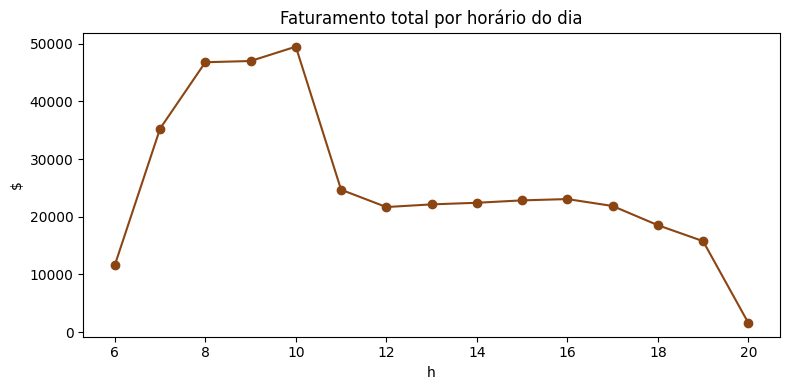

In [25]:
total_ganho_por_horario.sort_values(by='hour', ascending=False,inplace=True)

# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(
    total_ganho_por_horario['hour'], 
    total_ganho_por_horario['sum_unit_price'], 
    color=c1,
    marker='o'
)

plt.title('Faturamento total por horário do dia', fontsize=12)
plt.xlabel('h')
plt.ylabel('$')
plt.tight_layout()
plt.show()

### 5.6 Faturamento total por dia da semana

* Quarta-feira (Wednesday) parece ser o dia da semana com maior faturamento total
* Sexta-feira (Friday) parece ser o dia da semana com menor faturamento total.

In [26]:
# Criar uma coluna com o dia da semana
train['day_of_week'] = train['transaction_date'].dt.day_name()

# Agrupar pelo dia da semana e somar os ganhos
total_ganho_por_dia = train.groupby('day_of_week')['unit_price'].sum().reset_index()

# Ordenar os dias da semana na sequência correta
dias_da_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
total_ganho_por_dia['day_of_week'] = pd.Categorical(total_ganho_por_dia['day_of_week'], categories=dias_da_semana, ordered=True)
total_ganho_por_dia = total_ganho_por_dia.sort_values('day_of_week')
total_ganho_por_dia.columns = ['day_of_Week', 'sum_unit_price']

# Exibir o resultado
total_ganho_por_dia

,day_of_Week,sum_unit_price
1,Monday,56586.57
5,Tuesday,56114.22
6,Wednesday,56680.99
4,Thursday,53161.10
0,Friday,53001.08
2,Saturday,53532.68
3,Sunday,55695.31


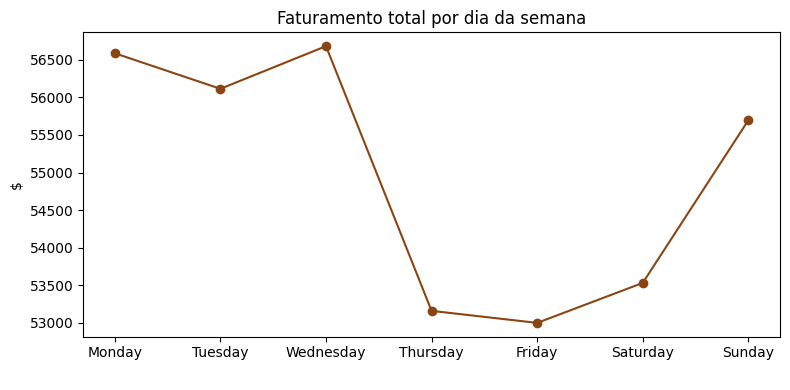

In [27]:
# Gráfico
plt.figure(figsize=(8, 4))
plt.plot(
    total_ganho_por_dia['day_of_Week'], 
    total_ganho_por_dia['sum_unit_price'], 
    color=c1,
    marker='o'
)

plt.title('Faturamento total por dia da semana', fontsize=12)
plt.xlabel(' ')
plt.ylabel('$')
plt.tight_layout()
plt.show()

# 6. Preparação dos dados

### 6.1 Agrupamento dos dados e definição das lags

* Os dados são divididos em lags para capturar a dependência temporal entre observações passadas e o valor atual ou futuro que queremos prever. Essa abordagem permite que os modelos aprendam padrões temporais e façam previsões baseadas em informações históricas;

* O método .shift() desloca os valores da coluna unit_price para "baixo" em x posições. Será utilizado para definir as lags;

* Neste projeto, foram definidas as lags de 7, 14 e 28 dias (uma semana, duas semanas e quatro semanas);

* As lags se tornarão as features, enquanto o `unit_price` será o target.

In [28]:
data_grouped = data.groupby('transaction_date').agg({'unit_price':'sum'}).reset_index()

In [29]:
# criação das lags

for lag in range(1, 29):
    data_grouped[f'unit_price_lag{lag}'] = data_grouped['unit_price'].shift(lag)

In [30]:
# Dados com as features a serem utilizadas pelo modelo

data_grouped

,transaction_date,unit_price,unit_price_lag1,unit_price_lag2,unit_price_lag3,unit_price_lag4,unit_price_lag5,unit_price_lag6,unit_price_lag7,unit_price_lag8,...,unit_price_lag19,unit_price_lag20,unit_price_lag21,unit_price_lag22,unit_price_lag23,unit_price_lag24,unit_price_lag25,unit_price_lag26,unit_price_lag27,unit_price_lag28
0,2023-01-01,1731.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,1743.95,1731.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,1826.60,1743.95,1731.80,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,1533.40,1826.60,1743.95,1731.80,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,1715.35,1533.40,1826.60,1743.95,1731.80,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2023-06-26,3980.45,3906.75,4012.65,3906.26,3753.25,4293.73,4258.06,4918.06,4614.24,...,3555.65,3227.40,3484.25,3453.45,3659.45,3537.65,3612.30,3406.48,3531.83,2846.65
177,2023-06-27,4010.05,3980.45,3906.75,4012.65,3906.26,3753.25,4293.73,4258.06,4918.06,...,4617.29,3555.65,3227.40,3484.25,3453.45,3659.45,3537.65,3612.30,3406.48,3531.83
178,2023-06-28,3335.75,4010.05,3980.45,3906.75,4012.65,3906.26,3753.25,4293.73,4258.06,...,4414.66,4617.29,3555.65,3227.40,3484.25,3453.45,3659.45,3537.65,3612.30,3406.48
179,2023-06-29,3162.35,3335.75,4010.05,3980.45,3906.75,4012.65,3906.26,3753.25,4293.73,...,4210.30,4414.66,4617.29,3555.65,3227.40,3484.25,3453.45,3659.45,3537.65,3612.30


### 6.2 Split temporal

* Os dados foram agrupados para a série temporal, dividos em lags (baseadas nos valores passados) e agora serão divididos em treino e teste novamente
* O objetivo é usar os dados dos primeiros 5 meses (janeiro, fevereiro, março, abril e maio) para prever o último mês (junho)
* O agrupamento será feito por dia, ou seja, 150 dias para treino (5 meses) e 30 dias para o teste (1 mês)

In [31]:
# Ponto de corte
train_end_date = '2023-05-31'

In [32]:
train = data_grouped[data_grouped['transaction_date'] <= train_end_date]
test = data_grouped[data_grouped['transaction_date'] > train_end_date]

print(f'Linhas do treino {train.shape[0]}')
print(f'Linhas do teste {test.shape[0]}')

Linhas do treino 151
Linhas do teste 30


### 6.3 Excluindo os NaNs

* Após os dados serem preparados para a série temporal, os NaNs gerados pela implementação das lags foram excluídos
* Pelo fato de as lags terem sido definidas previamente, os dados de teste foram preservados sem NaNs (sem perda de informação)

In [33]:
# Excluindo os NaNs

train = train.dropna()
train.shape

(123, 30)

In [34]:
# Treino sem NaNs

train.head()

,transaction_date,unit_price,unit_price_lag1,unit_price_lag2,unit_price_lag3,unit_price_lag4,unit_price_lag5,unit_price_lag6,unit_price_lag7,unit_price_lag8,...,unit_price_lag19,unit_price_lag20,unit_price_lag21,unit_price_lag22,unit_price_lag23,unit_price_lag24,unit_price_lag25,unit_price_lag26,unit_price_lag27,unit_price_lag28
28,2023-01-29,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,1563.48,2258.90,...,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40,1826.60,1743.95,1731.80
29,2023-01-30,1829.91,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,1563.48,...,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40,1826.60,1743.95
30,2023-01-31,1784.28,1829.91,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,...,1722.65,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40,1826.60
31,2023-02-01,1708.00,1784.28,1829.91,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,...,2106.50,1722.65,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40
32,2023-02-02,1762.85,1708.00,1784.28,1829.91,1455.20,1437.80,1856.15,1981.33,1904.40,...,2140.36,2106.50,1722.65,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35


In [35]:
# Checando o teste
test.head()

,transaction_date,unit_price,unit_price_lag1,unit_price_lag2,unit_price_lag3,unit_price_lag4,unit_price_lag5,unit_price_lag6,unit_price_lag7,unit_price_lag8,...,unit_price_lag19,unit_price_lag20,unit_price_lag21,unit_price_lag22,unit_price_lag23,unit_price_lag24,unit_price_lag25,unit_price_lag26,unit_price_lag27,unit_price_lag28
151,2023-06-01,3612.30,3406.48,3531.83,2846.65,3119.10,3750.95,3611.20,3531.10,3672.45,...,3882.58,3470.83,3630.36,3885.23,3955.62,4117.71,3285.40,2966.45,3328.70,3208.55
152,2023-06-02,3537.65,3612.30,3406.48,3531.83,2846.65,3119.10,3750.95,3611.20,3531.10,...,4025.15,3882.58,3470.83,3630.36,3885.23,3955.62,4117.71,3285.40,2966.45,3328.70
153,2023-06-03,3659.45,3537.65,3612.30,3406.48,3531.83,2846.65,3119.10,3750.95,3611.20,...,4046.23,4025.15,3882.58,3470.83,3630.36,3885.23,3955.62,4117.71,3285.40,2966.45
154,2023-06-04,3453.45,3659.45,3537.65,3612.30,3406.48,3531.83,2846.65,3119.10,3750.95,...,4284.48,4046.23,4025.15,3882.58,3470.83,3630.36,3885.23,3955.62,4117.71,3285.40
155,2023-06-05,3484.25,3453.45,3659.45,3537.65,3612.30,3406.48,3531.83,2846.65,3119.10,...,3600.40,4284.48,4046.23,4025.15,3882.58,3470.83,3630.36,3885.23,3955.62,4117.71


**Observações**

* Ao criar as lags no conjunto completo, elas são baseadas apenas em valores anteriores de unit_price
* As lags para o conjunto de teste são calculadas com base em valores que pertencem ao conjunto de treino, mas isso não representa vazamento porque as lags não "espiam" valores futuros que deveriam ser previstos
* O corte temporal (train_end_date = '2023-05-31') garante que todas as linhas do treino são anteriores às do teste
* Mesmo que as lags no teste tenham sido calculadas usando valores do treino, isso é aceitável, pois reflete o que aconteceria no mundo real (você sempre terá acesso a valores passados para calcular as lags no futuro)
* **Motivação:** dessa forma, os NaNs causados pelas lags aparecem no início da série (no treino), mas não afetam o conjunto de teste, pois o teste está intacto após a separação.

### 6.4 Separando features e target

In [36]:
X_train = train.drop(['transaction_date','unit_price'],axis=1)
y_train = train['unit_price']

In [37]:
X_test = test.drop(['transaction_date','unit_price'],axis=1)
y_test = test['unit_price']

In [38]:
# Demonstração dos dados

print('Dados de treino:')
display(X_train.head())
print(' ')
print('Dados de teste:')
display(pd.DataFrame(y_train.head()))

Dados de treino:


,unit_price_lag1,unit_price_lag2,unit_price_lag3,unit_price_lag4,unit_price_lag5,unit_price_lag6,unit_price_lag7,unit_price_lag8,unit_price_lag9,unit_price_lag10,...,unit_price_lag19,unit_price_lag20,unit_price_lag21,unit_price_lag22,unit_price_lag23,unit_price_lag24,unit_price_lag25,unit_price_lag26,unit_price_lag27,unit_price_lag28
28,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,1563.48,2258.90,2091.93,2210.58,...,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40,1826.60,1743.95,1731.80
29,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,1563.48,2258.90,2091.93,...,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40,1826.60,1743.95
30,1829.91,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,1563.48,2258.90,...,1722.65,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40,1826.60
31,1784.28,1829.91,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,1563.48,...,2106.50,1722.65,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35,1533.40
32,1708.00,1784.28,1829.91,1455.20,1437.80,1856.15,1981.33,1904.40,1986.40,1985.70,...,2140.36,2106.50,1722.65,1935.65,1977.05,2077.81,1938.23,1921.60,1580.15,1715.35


 
Dados de teste:


,unit_price
28,1455.20
29,1829.91
30,1784.28
31,1708.00
32,1762.85


# 7. Pré-processamento

`MinMax Scaler`

Foi realizado um pré-processamento a fim de testar o modelo de regressão linear. O scaler escolhido foi o MinMaxScaler. Trata-se de uma normalização dos dados que escala os valores de uma variável para um intervalo definido, geralmente entre 0 e 1. Ele é útil para transformar variáveis com diferentes escalas em uma escala comum, o que pode melhorar o desempenho de algoritmos que são sensíveis à magnitude dos dados, como a regressão linear.

In [39]:
scaler = MinMaxScaler()

In [40]:
# Transformando os dados de treino

X_train_transformed = scaler.fit_transform(X_train)

In [41]:
# Transformando os dados de teste

X_test_transformed = scaler.transform(X_test)

In [42]:
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X_train.columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=X_test.columns)

# 8. Modelagem exploratória

### 8.1 Linear regression (ElasticNet)

`Regularização`

A regularização é uma técnica usada para prevenir o overfitting, adicionando uma penalidade ao erro de previsão do modelo, incentivando a simplicidade. A regularização L1 (Lasso) penaliza a soma dos valores absolutos dos coeficientes, podendo zerá-los, enquanto a L2 (Ridge) penaliza a soma dos quadrados dos coeficientes, reduzindo suas magnitudes sem zerá-los. O `ElasticNet` combina ambas as penalidades L1 e L2, proporcionando uma abordagem equilibrada, ideal para situações com muitas variáveis correlacionadas, permitindo a seleção de variáveis e a regularização dos coeficientes simultaneamente.

In [43]:
# Instanciando o modelo

lr = ElasticNet(alpha=2.6, l1_ratio=1)

In [44]:
# Treinamento do modelo

lr.fit(X_train_transformed_df,y_train)
y_train_pred = lr.predict(X_train_transformed_df)
y_test_pred = lr.predict(X_test_transformed_df)

In [45]:
# R² com os dados de treino

np.round(r2_score(y_train,y_train_pred),2)

np.float64(0.91)

In [46]:
# R² com os dados de teste

np.round(r2_score(y_test,y_test_pred),2)

np.float64(0.49)

In [47]:
# RMSE do treino

np.round(np.sqrt(mean_squared_error(y_train,y_train_pred)),2)

np.float64(217.55)

In [48]:
# RMSE do teste

np.round(np.sqrt(mean_squared_error(y_test,y_test_pred)),2)

np.float64(322.79)

In [49]:
train['predict'] = y_train_pred
test['predict'] = y_test_pred

/tmp/ipykernel_32643/1391424195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = y_test_pred


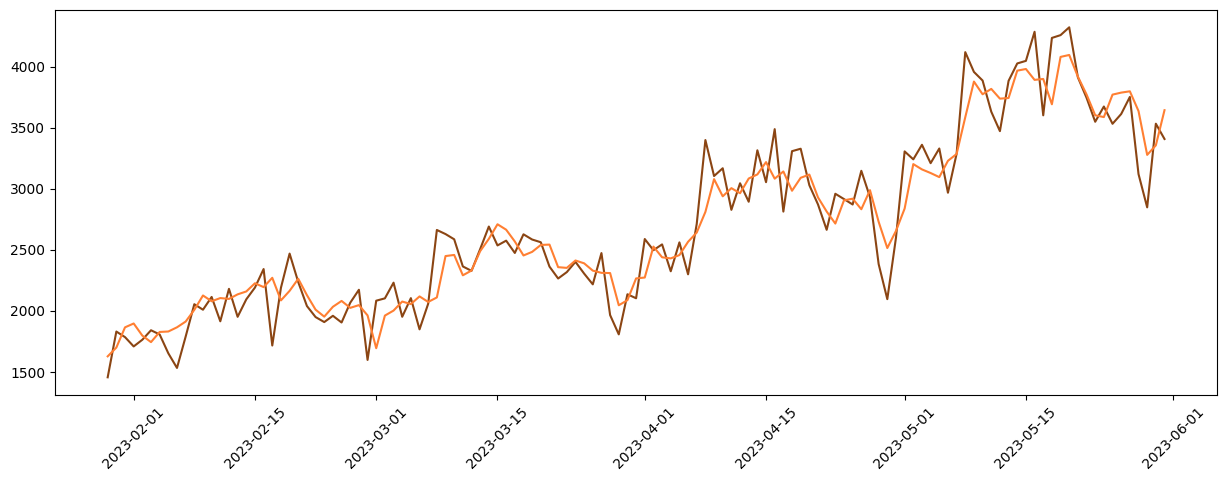

In [50]:
plt.figure(figsize=(15,5))
plt.plot(train['transaction_date'], train['unit_price'],color=c1)
plt.plot(train['transaction_date'], train['predict'],color=c4)
plt.xticks(rotation=45) 
plt.show()

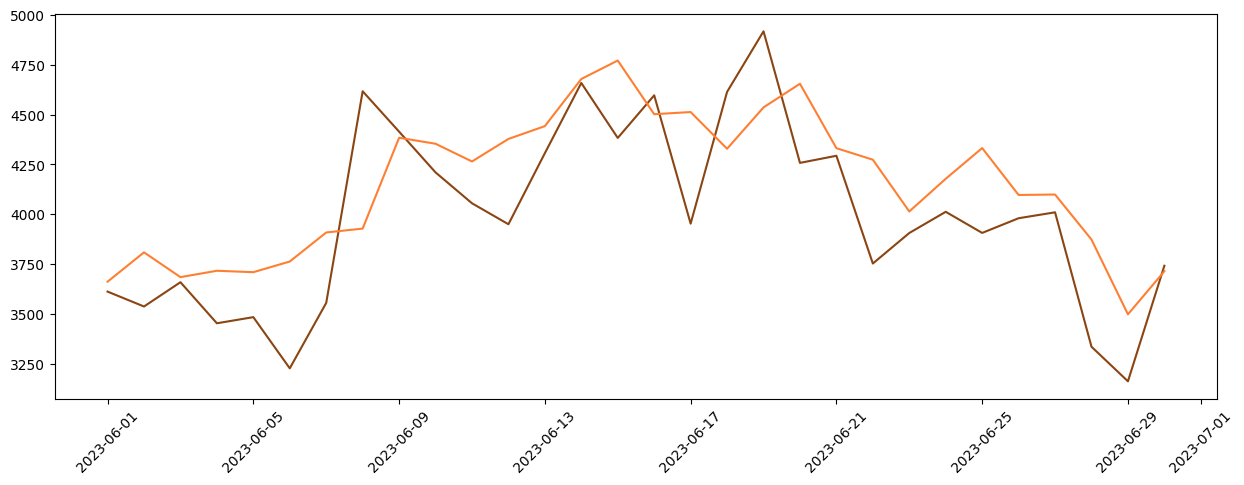

In [51]:
plt.figure(figsize=(15,5))
plt.plot(test['transaction_date'], test['unit_price'], color=c1)
plt.plot(test['transaction_date'], test['predict'],color=c4)
plt.xticks(rotation=45) 
plt.show()

In [52]:
# Feature importance

feature_importance = []

for i in zip(X_train_transformed_df.columns, lr.coef_):
    feature_importance.append(i)

In [53]:
df_feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'importance']).sort_values('importance', ascending=False)

<Axes: xlabel='importance', ylabel='feature'>

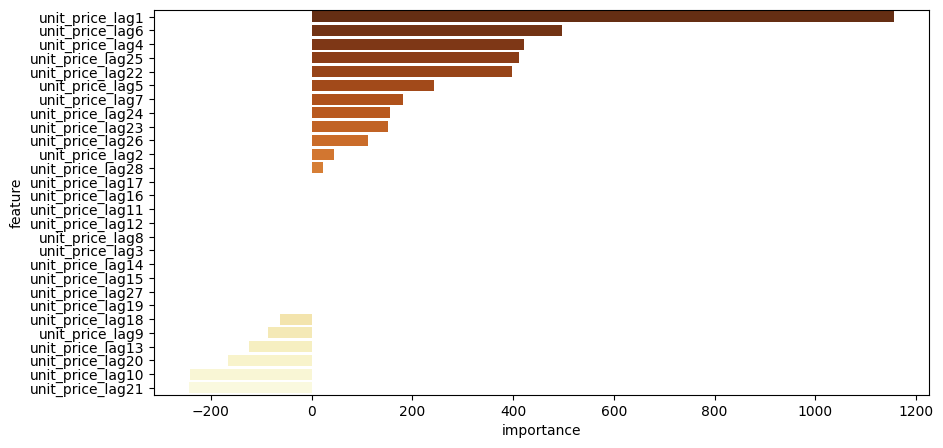

In [54]:
plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="feature", data=df_feature_importance, palette=c2)

As variáviáveis presentes no meio (3, 4, 5, 7, 8, 9, 11, 12, 16, 17) apresentaram menor importância na etapa de `Feature importance` indicada acima.

### 8.3 XGBoost

O modelo XGBoost não apresentou uma boa performance inicial em comparação com a regressão linear. Ele só obteve bons resultados quando o parâmetro booster="gblinear" foi definido, indicando que a abordagem linear foi mais eficaz para esse conjunto de dados. Ao optar pela configuração linear, foi possível alcançar uma performance satisfatória, evidenciando que o problema poderia ser melhor representado por uma abordagem linear em vez de uma árvore de decisão.

In [55]:
# Instanciando o modelo

xgb = XGBRegressor(n_estimators=100,learning_rate=0.1,booster="gblinear",alpha=0.02,feature_selector='shuffle',
                   reg_lambda=0.001,random_state=40,seed=40)

In [56]:
# Treinamento do modelo

xgb.fit(X_train_transformed_df,y_train)
y_train_pred = xgb.predict(X_train_transformed_df)
y_test_pred = xgb.predict(X_test_transformed_df)

In [57]:
# R² com os dados de treino

np.round(r2_score(y_train,y_train_pred),2)

np.float64(0.89)

In [58]:
# RMSE do treino

np.sqrt(mean_squared_error(y_train,y_train_pred))

np.float64(236.7985262756915)

In [59]:
# R² com os dados de teste

np.round(r2_score(y_test,y_test_pred),2)

np.float64(0.56)

In [60]:
# RMSE do teste

np.round(np.sqrt(mean_squared_error(y_test,y_test_pred)),2)

np.float64(299.6)

In [61]:
train['predict'] = y_train_pred
test['predict'] = y_test_pred

/tmp/ipykernel_32643/1391424195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict'] = y_test_pred


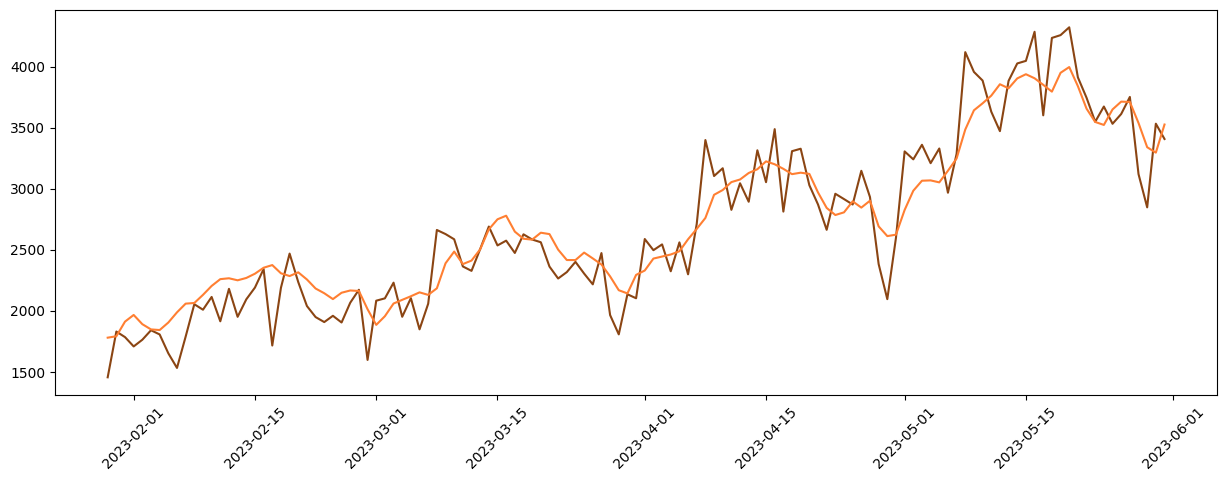

In [62]:
# Performance geral do treino

plt.figure(figsize=(15,5))
plt.plot(train['transaction_date'], train['unit_price'],color=c1)
plt.plot(train['transaction_date'], train['predict'],color=c4)
plt.xticks(rotation=45) 
plt.show()

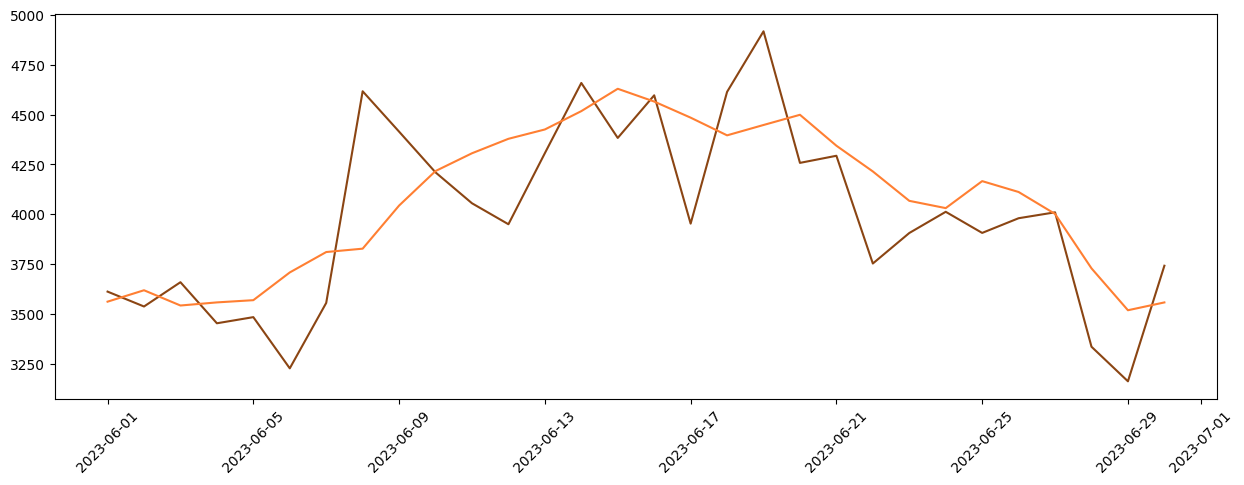

In [63]:
# Performance geral do teste

plt.figure(figsize=(15,5))
plt.plot(test['transaction_date'], test['unit_price'],color=c1)
plt.plot(test['transaction_date'], test['predict'],color=c4)
plt.xticks(rotation=45) 
plt.show()

In [64]:
# Feature importance

feature_importance = []

for i in zip(X_train_transformed_df.columns, xgb.feature_importances_):
    feature_importance.append(i)

In [65]:
df_feature_importance = pd.DataFrame(feature_importance, columns=['feature', 'importance']).sort_values('importance', ascending=False)

<Axes: xlabel='importance', ylabel='feature'>

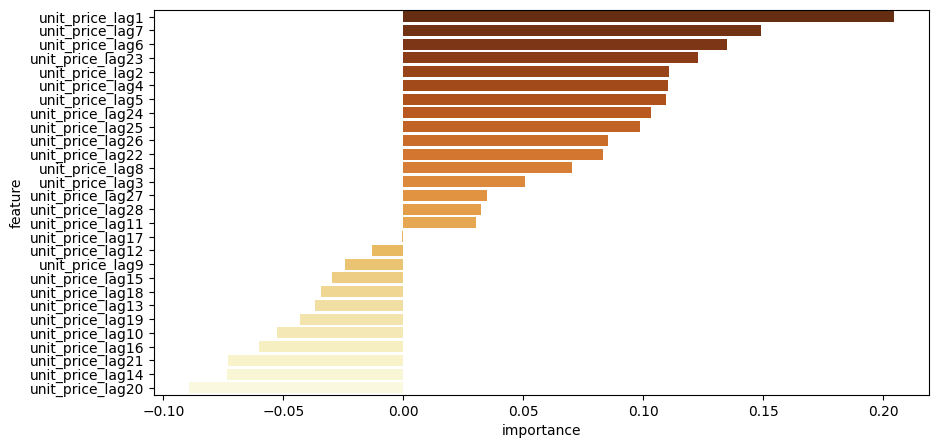

In [66]:
plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="feature", data=df_feature_importance, palette=c2)

As variáviáveis presentes no meio (11, 12, 17 e 27) apresentaram menor importância na etapa de Feature importance indicada acima.

# 9. Feature selection

`Select K Best`

Método que avalia individualmente cada feature em relação ao target, atribuindo uma pontuação e, em seguida, selecionando as k features com melhor pontuação.

In [67]:
from sklearn.feature_selection import SelectKBest, f_regression

In [68]:
rmse_array = []
k_array = list(range(1, 29))

In [69]:
 # Intervalo para k variando de 1 a 28

print(k_array)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [70]:
# Loop para verificar o número ideal de k features
for k in k_array:
    # Criar o seletor com as k características desejadas
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_transformed_df, y_train)
    X_test_selected = selector.transform(X_test_transformed_df)
    
    # Treinando o modelo XGBRegressor com os parâmetros fornecidos
    xgb = XGBRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        booster="gblinear", 
        alpha=0.02, 
        reg_lambda=0.001, 
        random_state=40, 
        seed=40
    )
    xgb.fit(X_train_selected, y_train)
    
    # Avaliando o modelo
    y_test_pred = xgb.predict(X_test_selected)
    
    # Calculando o RMSE para os dados de teste (manual)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    
    rmse_array.append(rmse)
    print(k, np.round(rmse,2))

1 489.98
2 428.93
3 396.16
4 381.42
5 385.4
6 387.18
7 393.74
8 369.35
9 345.06
10 343.49
11 344.34
12 345.42
13 347.86
14 348.75
15 338.26
16 332.59
17 325.11
18 327.53
19 320.7
20 309.93
21 306.78
22 303.47
23 302.85
24 301.58
25 297.4
26 295.8
27 296.34
28 301.65


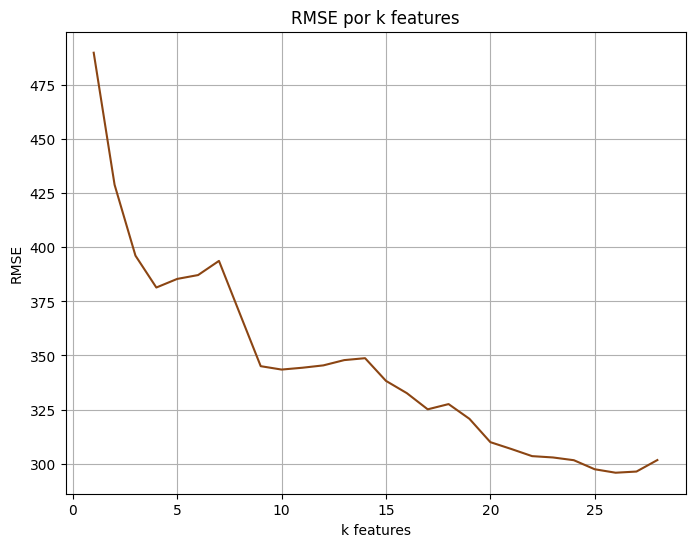

In [71]:
# Encontrando o número ideal de características
rmse_min = min(rmse_array)  # RMSE mínimo
k_min = k_array[np.argmin(rmse_array)]  # k correspondente ao RMSE mínimo

plt.figure(figsize=(8, 6))
plt.plot(k_array, rmse_array, c=c1)
plt.xlabel('k features')
plt.ylabel('RMSE')
plt.title('RMSE por k features')
plt.grid()
plt.show()

In [72]:
# Exibindo o melhor k (menor RMSE)

print(f'O número ideal de features é {k_min}, com RMSE de {np.round(rmse_min,2)}')

O número ideal de features é 26, com RMSE de 295.8


A diferença no RMSE foi mínima ao comparar o uso de 26 features com as 28 features. Dado que a melhoria foi pouco significativa, optou-se por manter as 28 features.

# 10. Otimização de hiperparâmetros (Bayesian search)

`Bayesian search`

A busca Bayesiana utiliza um modelo probabilístico para prever o desempenho do modelo com base nos hiperparâmetros já avaliados. A cada iteração, ela atualiza o modelo probabilístico e decide quais valores testar em seguida, priorizando áreas promissoras do espaço de busca. Isso a torna mais eficiente, pois evita testar combinações desnecessárias.

In [73]:
# Versão compatível do sklearn

#pip install scikit-learn==1.5.0

In [74]:
from skopt import BayesSearchCV

In [75]:
# Para a validação cruzada com séries temporais

tscv = TimeSeriesSplit(n_splits=3)

In [76]:
# Modelo base
xgb = XGBRegressor(
    booster="gblinear",
    feature_selector="shuffle",
    random_state=40,
    objective="reg:squarederror"
)

In [77]:
# Parâmetros

param = {
    'n_estimators': (80, 500,'uniform'),
    'learning_rate': (0.001, 0.1, 'log-uniform'),
    'alpha': (0.01, 0.1, 'log-uniform'),
    'reg_lambda': (0.001, 0.01, 'log-uniform')
}

In [78]:
# Bayesian Search

bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param,
    n_iter=400,                 
    cv=tscv,                              
    scoring="neg_mean_squared_error",
    random_state=40,
    n_jobs=-1,
    refit=True
)

In [79]:
# Modelo

# bayes_search.fit(X_train_transformed_df,y_train)

In [80]:
# Melhores hiperparâmetros encontrados

# print("Melhores hiperparâmetros:", bayes_search.best_params_)

In [81]:
# Resultado da validação cruzada

# print("Melhores hiperparâmetros:", np.round(np.sqrt(bayes_search.best_score_*-1),2))

$ 344.54.

In [82]:
# Avaliação no conjunto de teste

# y_pred = bayes_search.best_estimator_.predict(X_test_transformed_df)
# print("Erro Quadrático Médio no teste:", np.round(np.sqrt(mean_squared_error(y_test, y_pred)),2))

$ 351.89.

Apesar da otimização com o Bayesian Search, os melhores parâmetros encontrados não apresentaram uma performance melhor se comparado com a etapa de modelagem inicial. Sendo assim, os parâmetros da modelagem encontrados previamente serão mantidos.

# 11. Modelagem final

Como mencionado na seção anterior, o modelo selecionado foi o XGBoost. Na avaliação final, foi considerado o desempenho do modelo com os parâmetros definidos na etapa de modelagem inicial, antes da otimização com o Bayesian Search, devido à sua superioridade de performance.

In [83]:
df_full = pd.concat([train, test])

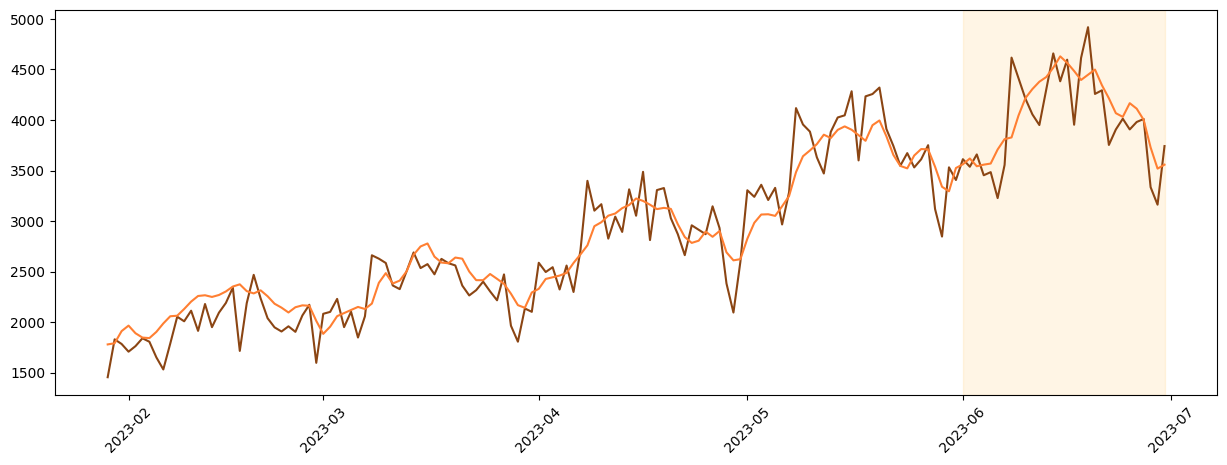

In [84]:
# Treino e teste

plt.figure(figsize=(15,5))
plt.plot(df_full['transaction_date'], df_full['unit_price'],color=c1)
plt.plot(df_full['transaction_date'], df_full['predict'],color=c4)
plt.axvspan('2023-06-01','2023-06-30', alpha=0.1,color=c5)
plt.xticks(rotation=45) 
plt.show()

In [87]:
# Avaliação final (MAE, MSE, RMSE, R²) -> COLOCAR POR DIA

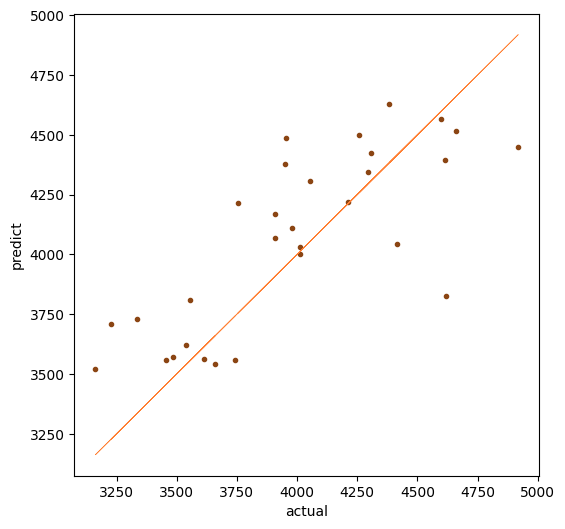

In [85]:
# Gráfico de resíduos total (predito x atual)

plt.figure(figsize=(6,6))
plt.plot(test['unit_price'], test['predict'],color=c1, ls='',marker='.')
plt.plot(test['unit_price'], test['unit_price'], ls='-', c=c4, lw=0.5) # linha diagonal
plt.xlabel('actual')
plt.ylabel('predict')
plt.show()

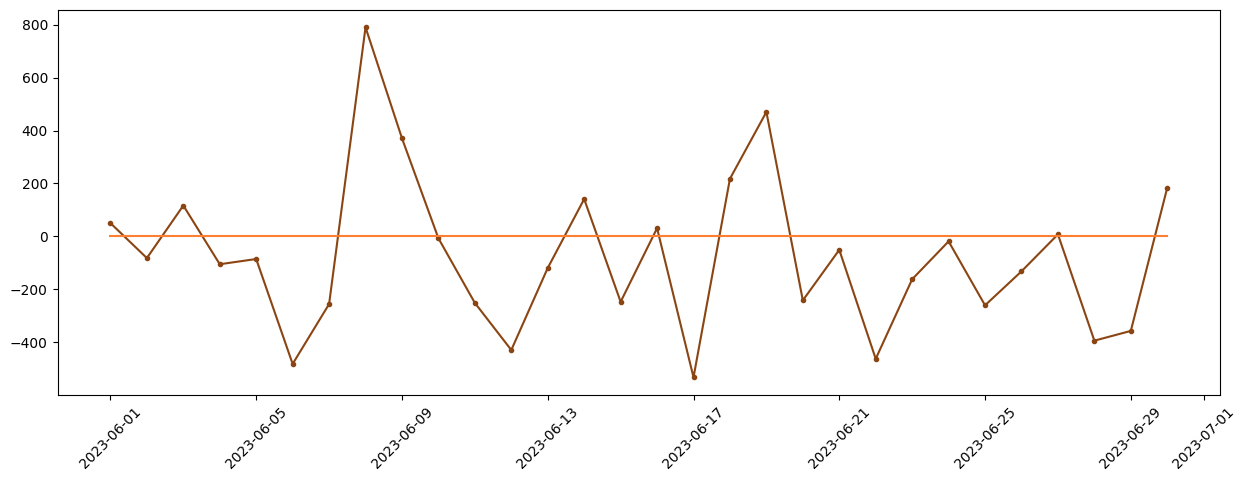

In [86]:
# Resíduo do teste por dia

plt.figure(figsize=(15,5))
plt.plot(test['transaction_date'], test['unit_price']-test['predict'],color=c1, marker='.')
plt.plot(test['transaction_date'],np.zeros(len(test['transaction_date'])),c=c4) # linha central
plt.xticks(rotation=45) 
plt.show()

# 12. Análise de negócio

In [88]:
# Análise segmentada

In [89]:
# Análise financeira

from scipy import stats

confidence = 0.99
absolute_errors = np.abs(y_test_pred - y_test)

In [90]:
stats.t.interval(confidence, len(absolute_errors)-1,
                loc=absolute_errors.mean(),
                scale=stats.sem(absolute_errors))

(np.float64(152.33601833909327), np.float64(334.62861707757327))

In [91]:
# Comentar intervalo de confiança